# End-to-end demand forecasting: cold start predictions

Author: Andrii Kruchko

Version Date: 02/17/2023

[DataRobot's API reference documentation](https://docs.datarobot.com/en/docs/api/reference/index.html)

## Summary

This notebook illustrates an end-to-end demand forecasting workflow in DataRobot. Time series forecasting in DataRobot has a suite of tools and approaches to handle highly complex multiseries problems. These include:

- Automatic feature engineering and creation of lagged variables across multiple data types, as well as training dataset creation
- Diverse approaches for time series modeling with text data, learning from cross-series interactions and scaling to hundreds or thousands of series
- Feature generation from an uploaded calendar of events file specific to your business or use case
- Automatic backtesting controls for regular and irregular time series
- Training dataset creation for an irregular series via custom aggregations
- Segmented modeling, hierarchical clustering for multi-series  models, text support, and ensembling
- Periodicity and stationarity detection and automatic feature list creation with various differencing strategies
- Cold start modeling on series with limited or no history
- Insights for models

This is the second notebook from the demand forecasting series. It digs deeper into handling cold-start series, and checking data drift in production. The next notebook in this series will focus on deploying a web-based application for what-if analysis for promotion planning. [The first notebook](https://github.com/datarobot-community/ai-accelerators/tree/main/end-to-end/End_to_end_demand_forecasting) provides a framework to inspect and handle common data and modeling challenges, identifying common pitfalls in real-life time series data, and leaving it to the reader to dig deeper on specific issues. 

The dataset consists of 50 series (46 SKUs across 22 stores) over a two year period with varying series history, typical of a business releasing and removing products over time.

DataRobot will be used for model training, model selection, deployment, and to make predictions. Snowflake will work as a data source for both training and testing, and as a storage to write back predictions. This workflow, however, applies to any data source, e.g. Redshift, S3, Big Query, Synapse, etc. For examples of data loading from other environments, check out the other end-to-end examples in this GitHub repo.

The following steps are covered:

- [Ingest the data from Snowflake into AI Catalog within DataRobot](#data_prep)
- [Run a new DataRobot project](#modeling)
- [Get the insights from the top model](#insights)
- [Deploy the recommended model](#deployment)
- [Define and run a job to make predictions and write them back to Snowflake](#preds)

<a id='eda'></a>
### Cold start overview

Cold start means making predictions on a series that have limited `(warm start)` or no history `(cold start)` at the prediction time.

A business may have such series due to: 

- New products
- New stores
- A new product is launched in a store that is already being sold in other stores

<img src="cold_start.png" alt="cold start" />

This notebook explores the following solution methods:

- Prediction-based:
    - Use average forecasts of `all` or `similar` ongoing series to make predictions for warm and cold start series
    - Impute the FDW for all non-KA features using the averages from `all` or `similar` ongoing series to make predictions 
- Modeling:
    - Run a project with new series support to make predictions for all series
    - Run two projects:
        - One with new series support to make predictions only for warm and cold start series
        - One without new series support to make predictions only for ongoing series


## Setup

### Optional: Import public demo data

For this workflow, you can download publicly available datasets (training, scoring, and calendar data) from DataRobot's S3 bucket to your database or load them into your DataRobot instance. 

If you are using Snowflake, you will need to update the fields below with your Snowflake information. Data will be loaded and created in your Snowflake instance. You will also need the following files found in the same repo as this notebook:

* dr_utils.py
* datasets.yaml

Once you are done with this notebook, remember to delete the data from your Snowflake instance.

In [1]:
#requires Python 3.8 or higher
from dr_utils import prepare_demo_tables_in_db

Fill out the credentials for your Snowflake instance. You will need write access to a database.

In [ ]:
db_user = 'your_username' # Username to access Snowflake database
db_password = 'your_password' # Password 
account = 'account' # Snowflake account identifier
db = 'YOUR_DB_NAME' # Database to Write_To
warehouse = 'YOUR_WAREHOUSE' # Warehouse 
schema = 'YOUR_SCHEMA' # Schema

Use the util function to pull the data from DataRobot's public S3 and import into your Snowflake instance.

In [3]:
response = prepare_demo_tables_in_db(
    db_user = db_user,                        
    db_password = db_password,                
    account = account,                        
    db = db,                                  
    warehouse = warehouse,                     
    schema = schema
)

******************************
table: ts_demand_forecasting_train


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2019-05-06,388.0,44.0,69.0,55.428571,8.182443,243.0,1.0,44.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2019-05-13,318.0,37.0,62.0,45.428571,8.079958,210.0,1.0,44.8,store_130,SKU_120931082,cat_1160


writing ts_demand_forecasting_train to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_train.csv
******************************
table: ts_demand_forecasting_scoring


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160


writing ts_demand_forecasting_scoring to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_scoring.csv
******************************
table: ts_demand_forecasting_calendar


,date,event_type
0,2017-01-01,New Year's Day
1,2017-01-02,New Year's Day (Observed)


writing ts_demand_forecasting_calendar to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_calendar.csv
******************************
table: ts_demand_forecasting_test_warm_cold


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY,SERIES_TYPE
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing


writing ts_demand_forecasting_test_warm_cold to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_test_warm_cold.csv
******************************
table: ts_demand_forecasting_scoring_warm_cold


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY,SERIES_TYPE
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing


writing ts_demand_forecasting_scoring_warm_cold to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_scoring_warm_cold.csv
******************************
table: ts_demand_forecasting_scoring_warm_cold_hist_inputted


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY,SERIES_TYPE
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing


writing ts_demand_forecasting_scoring_warm_cold_hist_inputted to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_scoring_warm_cold_hist_inputted.csv


### Import libraries

In [4]:
from datetime import datetime as dt
from platform import python_version

import pandas as pd
import datarobot as dr
import matplotlib.pyplot as plt

import dr_utils as dru

print('Python version:', python_version())
print('Client version:', dr.__version__)

Python version: 3.11.1
Client version: 3.0.2


### Connect to DataRobot

1. In DataRobot, navigate to **Developer Tools** by clicking on the user icon in the top-right corner. From here you can generate a API Key that you will use to authenticate to DataRobot. You can find more details on creating an API key [in the DataRobot documentation](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html#create-a-datarobot-api-key). 

2. Determine your DataRobot API Endpoint. The API endpoint is the same as your DataRobot UI root. Replace {datarobot.example.com} with your deployment endpoint.

    API endpoint root: `https://{datarobot.example.com}/api/v2`
    
    For users of the AI Cloud platform, the endpoint is `https://app.datarobot.com/api/v2`
    
3. After obtaining your API Key and endpoint, there are several options to [connect to DataRobot](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html#configure-api-authentication).

In [5]:
# Instantiate the DataRobot connection

DATAROBOT_API_TOKEN = "" # Get this from the Developer Tools page in the DataRobot UI
# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = "https://app.datarobot.com/" # This should be the URL you use to access the DataRobot UI

client = dr.Client(
    token=DATAROBOT_API_TOKEN, 
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix='AIA-E2E-TS-88' #Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

<a id='data_prep'></a>
## Data preparation

### Define variables

In [6]:
date_col = 'DATE'
series_id = 'STORE_SKU'
target = 'UNITS'

### Configure a data connection

DataRobot supports connections to a wide variety of databases through AI Catalog, allowing repeated access to the database as an AI Catalog Data Store. You can find the examples [in the DataRobot documentation](https://docs.datarobot.com/en/docs/data/connect-data/data-sources/index.html).

[Credentials for the connection to your Data Store can be securely stored within DataRobot](https://docs.datarobot.com/en/docs/data/connect-data/stored-creds.html). They will be used during the dataset creation in the AI Catalog, and can be found under the `Data Connections` tab in DataRobot.  

If you don't have credentials and a datastore created, uncomment and run the cell below.

In [ ]:
# # Find the driver ID from name
# Can be skipped if you have the ID - showing the code here for completeness
# for d in dr.DataDriver.list():
#     if d.canonical_name in 'Snowflake (3.13.9 - recommended)':
#         print((d.id, d.canonical_name))
        
# # Create a datastore and datastore ID
# data_store = dr.DataStore.create(data_store_type='jdbc', canonical_name='Snowflake Demo DB', driver_id='626bae0a98b54f9ba70b4122', jdbc_url= db_url)
# data_store.test(username=db_user, password=db_password)

# # Create and store credentials to allow the AI Catalog access to this database
# # These can be found in the Data Connections tab under your profile in DataRobot  
# cred = dr.Credential.create_basic(name='test_cred',user=db_user, password=db_password,)

Use the snippet below to find a credential and a data connection (AKA a datastore).

In [7]:
creds_name = 'your_stored_credential'
data_store_name = 'your_datastore_name'

credential_id = [cr.credential_id for cr in dr.Credential.list() if cr.name == creds_name][0]
data_store_id = [ds.id for ds in dr.DataStore.list() if ds.canonical_name == data_store_name][0]

Use the snippet below to create or get an existing data connection based on a query and upload a training dataset into the AI Catalog.

In [8]:
data_source_train, dataset_train = dru.create_dataset_from_data_source(
    data_source_name='ts_training_data', query=f'select * from {db}.{schema}."ts_demand_forecasting_train";',
    data_store_id=data_store_id, credential_id=credential_id)

new data source: DataSource('ts_training_data')


Use the snippet below to create or get an existing data connection based on a query and upload a scoring dataset into the AI Catalog.

In [9]:
data_source_scoring, dataset_scoring = dru.create_dataset_from_data_source(
    data_source_name='ts_scoring_data', query=f'select * from {db}.{schema}."ts_demand_forecasting_scoring_warm_cold";',
    data_store_id=data_store_id, credential_id=credential_id)

new data source: DataSource('ts_scoring_data')


Use the following snippet to create or get an existing data connection based on a query and upload a calendar dataset into the AI Catalog.

In [10]:
data_source_calendar, dataset_calendar = dru.create_dataset_from_data_source(
    data_source_name='ts_calendar', query=f'select * from {db}.{schema}."ts_demand_forecasting_calendar";',
    data_store_id=data_store_id, credential_id=credential_id)

new data source: DataSource('ts_calendar')


#### New series overview

The following snippets are optional and can be used to get data to investigate before modeling.

In [11]:
df = dataset_train.get_as_dataframe()
df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
print('the original data shape   :', df.shape)
print('the total number of series:', df[series_id].nunique())
print('the min date:', df[date_col].min())
print('the max date:', df[date_col].max())
df.head()

the original data shape   : (8589, 13)
the total number of series: 50
the min date: 2019-05-06 00:00:00
the max date: 2022-10-24 00:00:00


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2019-05-06,388.0,44.0,69.0,55.428571,8.182443,243.0,1.0,44.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2019-05-13,318.0,37.0,62.0,45.428571,8.079958,210.0,1.0,44.8,store_130,SKU_120931082,cat_1160
2,store_130_SKU_120931082,2019-05-20,126.0,13.0,23.0,18.000000,3.915780,118.0,0.0,44.8,store_130,SKU_120931082,cat_1160
3,store_130_SKU_120931082,2019-05-27,285.0,23.0,65.0,40.714286,14.067863,197.0,1.0,44.8,store_130,SKU_120931082,cat_1160
4,store_130_SKU_120931082,2019-06-03,93.0,10.0,20.0,13.285714,3.352327,87.0,0.0,44.8,store_130,SKU_120931082,cat_1160


In [12]:
df_scoring = dataset_scoring.get_as_dataframe()
df_scoring[date_col] = pd.to_datetime(df_scoring[date_col], format='%Y-%m-%d')
print('the original data shape   :', df_scoring.shape)
print('the total number of series:', df_scoring[series_id].nunique())
print('the min date:', df_scoring[date_col].min())
print('the max date:', df_scoring[date_col].max())
df_scoring.head()

the original data shape   : (1170, 14)
the total number of series: 70
the min date: 2022-07-04 00:00:00
the max date: 2022-11-21 00:00:00


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY,SERIES_TYPE
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
2,store_130_SKU_120931082,2022-07-18,90.0,10.0,18.0,12.857143,3.132016,85.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
3,store_130_SKU_120931082,2022-07-25,77.0,4.0,20.0,11.000000,5.000000,67.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing
4,store_130_SKU_120931082,2022-08-01,85.0,6.0,26.0,12.142857,6.466028,82.0,0.0,22.8,store_130,SKU_120931082,cat_1160,ongoing


Now, check the scoring dataset:
- Check how many new series you have compared to the training data
- Check the number of series by type: ongoing, warm, and cold

In [13]:
print('# of new series:', len(set(df_scoring[series_id].unique()) - set(df[series_id].unique())))
print('# of series by type:')
df_scoring.groupby('SERIES_TYPE')[[series_id]].nunique()

# of new series: 20
# of series by type:


,STORE_SKU
SERIES_TYPE,
cold,10
ongoing,50
warm,10


Next, check if the new series were included in the training dataset:

In [14]:
sids_new = df_scoring[df_scoring['SERIES_TYPE'] != 'ongoing'][series_id].unique()
df[df[series_id].isin(sids_new)]

,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY


The plot below shows how the number of series evolved over time for the scoring dataset. The red vertical line indicates the training data end date. The scoring dataset contains ten new series which were not used for the training purposes, but they at least have some history before the training data end date (a `warm` series). Also, it contains ten new series which started after the training data end date (a `cold` series).

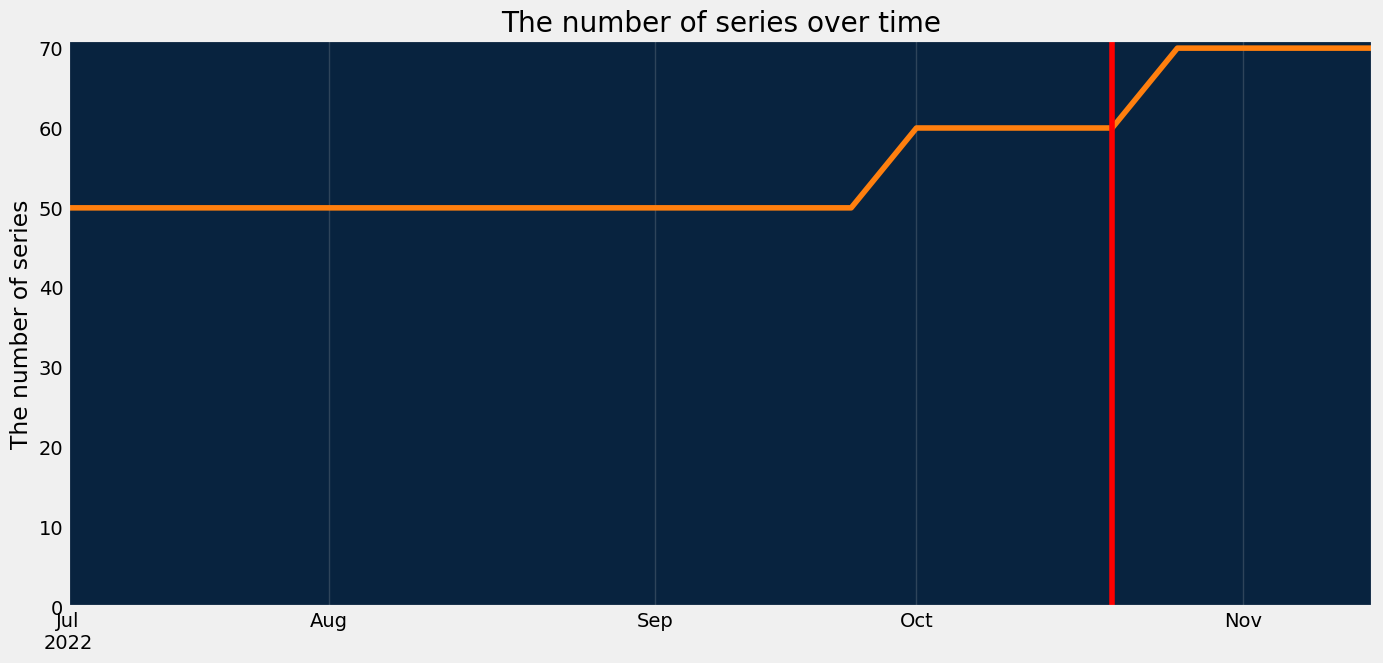

In [15]:
dru.plot_series_count_over_time(df_scoring, date_col, series_id)
plt.axvline(df[date_col].max(), c='red')

<a id='modeling'></a>
## Modeling

The next step after the data preparation and before modeling is [to specify the modeling parameters](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.28.0/reference/modeling/spec/time_series.html#):

- *Features known in advance* are things you know in the future, such as product metadata or a planned marketing event. If all features are known in advance, use the setting `default_to_known_in_advance`.

- *Do not derive features* will be excluded from deriving time-related features. If all features should be excluded, `default_to_do_not_derive` can be used.

- `metric` is used for evaluating models. [DataRobot supports a wide variety of metrics](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html#optimization-metrics). The metric used depends on the use case. If the value is not specified, DataRobot suggests a metric based on the target distribution.

- `feature_derivation_window_start` and `feature_derivation_window_end` define the feature derivation window (FDW). The FDW represents the rolling window that is used to derive time series features and lags. FDW definition should be long enough to capture relevant trends to your use case. On the other hand, FDW shouldn't be too long (e.g., 365 days) because it shrinks the available training data and increases the size of the feature list. Older data does not help the model learn recent trends. It is not necessary to have a year-long FDW to capture seasonality; DataRobot auto-derives features (month indicator, day indicator), as well as learns effects near calendar events (if a calendar is provided), in addition to blueprint specific techniques for seasonality.

- `gap_duration` is the duration of the gap between training and validation/holdout scoring data, representing delays in data availability. For example, at prediction time, if events occuring on Monday aren't reported or made available until Wednesday, you would have a gap of two days. This can occur with reporting lags or with data that requires some form of validation before being stored on a system of record.            

- `forecast_window_start` and `forecast_window_end` defines the forecast window (FW). It represents the rolling window of future values to predict. FW depends on a business application of the model predictions.

- `number_of_backtests` and `validation_duration`. Proper backtest configuration helps evaluate the model’s ability to generalize to the appropriate time periods. The main considerations during the backtests specification are listed below.
    - Validation from all backtests combined should span the region of interest.
    - Fewer backtests means the validation lengths might need to be longer.
    - After the specification of the appropriate validation length, the number of backtests should be adjusted until they span a full region of interest.
    - The validation duration should be at least as long as your best estimate of the amount of time the model will be in production without retraining.


- `holdout_start_date` with one of `holdout_end_date` or `holdout_duration` can be added additionally. DataRobot will define them based on `validation_duration` if they were not specified.


- `calendar_id` is the ID of the previously created calendar. DataRobot automatically creates features based on the calendar events (such as “days to next event” ). There are several options to create a calendar:
    
    - From an AI Catalog dataset:
        ```python
        calendar = dr.CalendarFile.create_calendar_from_dataset(dataset_id)
        
        
        ```
    - Based on the provided country code and dataset start date and end dates:
        ```python
        calendar = dr.CalendarFile.create_calendar_from_country_code(country_code, start_date, end_date)
        
        
        ```
    - From a local file:
        ```python
        calendar = dr.CalendarFile.create(path_to_calendar_file)
        
        
        ```

- `allow_partial_history_time_series_predictions` - Not all blueprints are designed to predict on new series with only partial history, as it can lead to suboptimal predictions. This is because for those blueprints the full history is needed to derive the features for specific forecast points. "Cold start" is the ability to model on series that were not seen in the training data; partial history refers to prediction datasets with series history that is only partially known (historical rows are partially available within the feature derivation window). If `True`, Autopilot will run the blueprints optimized for cold start and also for partial history modeling, eliminating models with less accurate results for partial history support.

- `segmented_project` set to `True` and the cluster name `cluster_id` can be used for segmented modeling. This feature offers the ability to build multiple forecasting models simultaneously. DataRobot creates multiple projects “under the hood”. Each project is specific to its own data per `cluster_id`. The model benefits by having forecasts tailored to the specific data subset, rather than assuming that the important features are going to be the same across all of series. The models for different `cluster_id`s will have features engineered specifically from cluster-specific data. The benefits of segmented modeling also extend to deployments. Rather than deploying each model separately, we can deploy all of them at once within one segmented deployment.

> The function `dr.helpers.partitioning_methods.construct_duration_string()` can be used to construct a valid string representing the `gap_duration`, `validation_duration` and `holdout_duration` duration in accordance with ISO8601.

### Create a calendar

Create a calendar based on the dataset in the AI Catalog.

In [16]:
calendar = dr.CalendarFile.create_calendar_from_dataset(dataset_id=dataset_calendar.id, calendar_name=dataset_calendar.name)
calendar_id = calendar.id

### Configure modeling settings

In [17]:
features_known_in_advance = ['STORE', 'SKU', 'SKU_CATEGORY', 'PROMO_MAX']
do_not_derive_features = ['STORE', 'SKU', 'SKU_CATEGORY']

params_ongoing = {
    'metric': None,
    'features_known_in_advance': features_known_in_advance,
    'do_not_derive_features': do_not_derive_features,
    
    'target': target,
    'mode': 'quick',
    
    'datetime_partition_column': date_col,
    'multiseries_id_columns': [series_id],
    'use_time_series': True,
    
    'feature_derivation_window_start': None,
    'feature_derivation_window_end': None,
    
    'gap_duration': None,
    
    'forecast_window_start': None,
    'forecast_window_end': None,
    
    'number_of_backtests': None,
    'validation_duration': None,
    
    'calendar_id': calendar_id,
    
    'allow_partial_history_time_series_predictions': False
}

### Create and run projects

In order to try all cold start solution methods we are going to run two projects on the same training data. 

Use the following snippet to create and run the project without new series support.

In [18]:
project_ongoing = dru.run_project(data=dataset_train, params=params_ongoing, notes='_ongoing_series')

DataRobot will define FDW and FD automatically.
2023-02-20 15:52:14.784863 start: UNITS_ongoing_series_20230220_1552


Let's reuse the previous projects parameters, but we'll set `allow_partial_history_time_series_predictions=True` to run the project with new series support.

In [19]:
params_warm_cold = params_ongoing.copy()
params_warm_cold['allow_partial_history_time_series_predictions'] = True

project_warm_cold = dru.run_project(data=dataset_train, params=params_warm_cold, notes='_warm_cold_series')

DataRobot will define FDW and FD automatically.
2023-02-20 15:55:06.088153 start: UNITS_warm_cold_series_20230220_1555


In [20]:
project_ongoing.wait_for_autopilot(verbosity=dr.enums.VERBOSITY_LEVEL.SILENT)
project_warm_cold.wait_for_autopilot(verbosity=dr.enums.VERBOSITY_LEVEL.SILENT)

<a id='insights'></a>
## Model evaluation and insights

### Retrieve models

Select the most accurate model per project from the corresponding Leaderboards.

In [21]:
model_scores_ongoing = dru.get_leaderboard(project_ongoing)
model_ongoing = model_scores_ongoing['model'][0]
print(model_ongoing.id, model_ongoing)
print('RMSE:', model_ongoing.metrics['RMSE']['backtesting'])

63f37bb8f0892a208ffde078 DatetimeModel('RandomForest Regressor')
RMSE: 44.02571


In [22]:
model_scores_warm_cold = dru.get_leaderboard(project_warm_cold)
model_warm_cold = model_scores_warm_cold['model'][0]
print(model_warm_cold.id, model_warm_cold)
print('RMSE:', model_warm_cold.metrics['RMSE']['backtesting'])

63f37c68b60176376bce714b DatetimeModel('eXtreme Gradient Boosting Regressor with Early Stopping and New Series Support')
RMSE: 43.79093


### Accuracy over time

[Accuracy over time](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/aot.html#accuracy-over-time) helps visualize how predictions change over time compared to actuals.

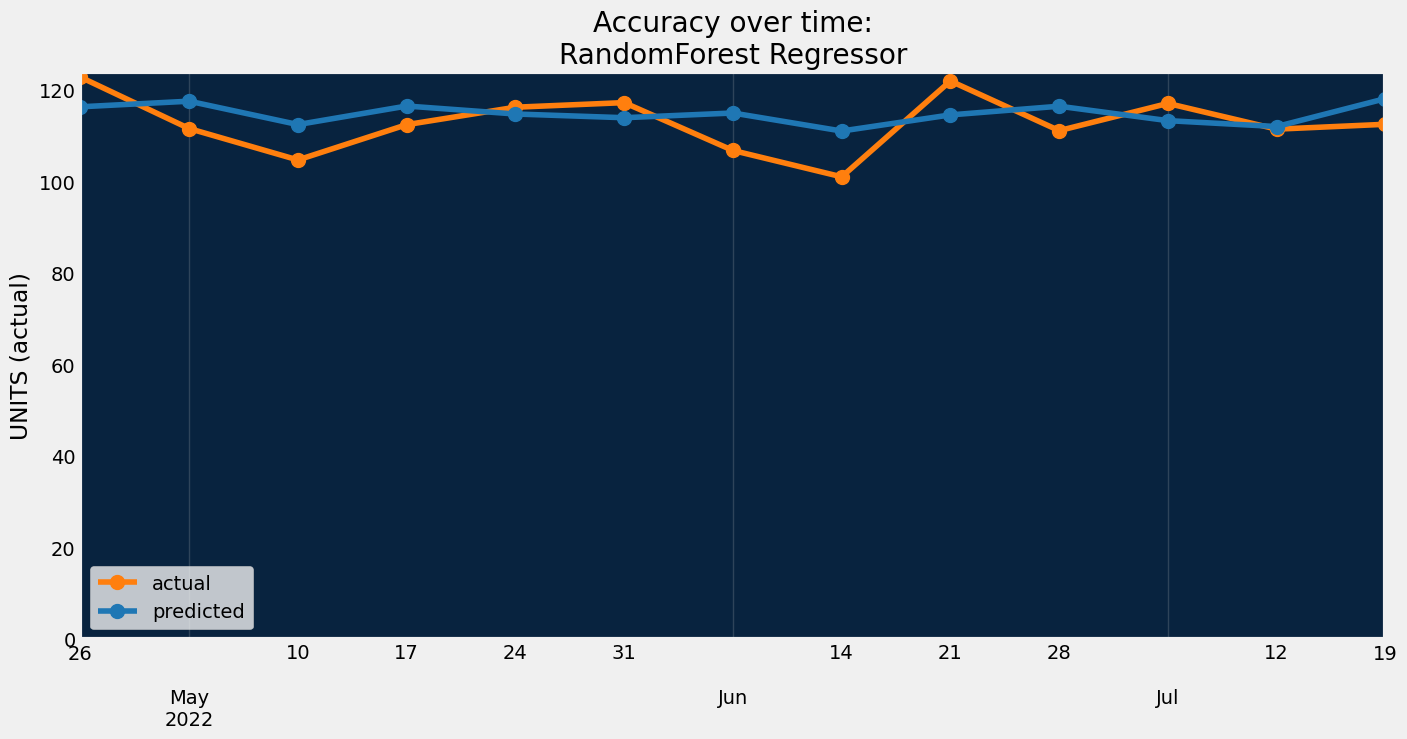

In [23]:
dru.plot_accuracy_over_time(project_ongoing, model_ongoing)

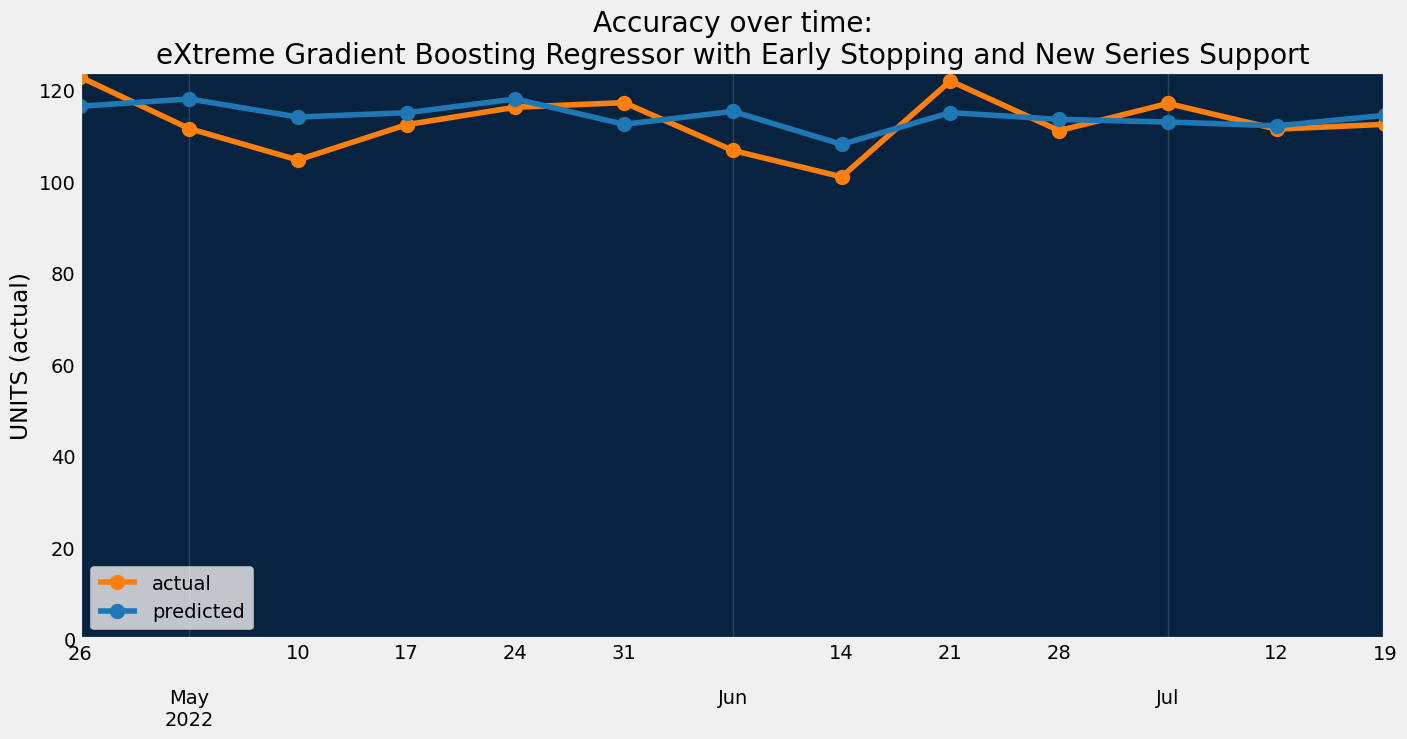

In [24]:
dru.plot_accuracy_over_time(project_warm_cold, model_warm_cold)

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html#feature-impact) is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once you have had DataRobot compute the feature impact for a model, that information is saved with the project.

Feature Impact measures how important a feature is in the context of a model. That is, it measures how much the accuracy of a model would decrease if that feature were removed.

Note that the diversity of features created is providing signal to the model. 

The top seven important features are similar between models.

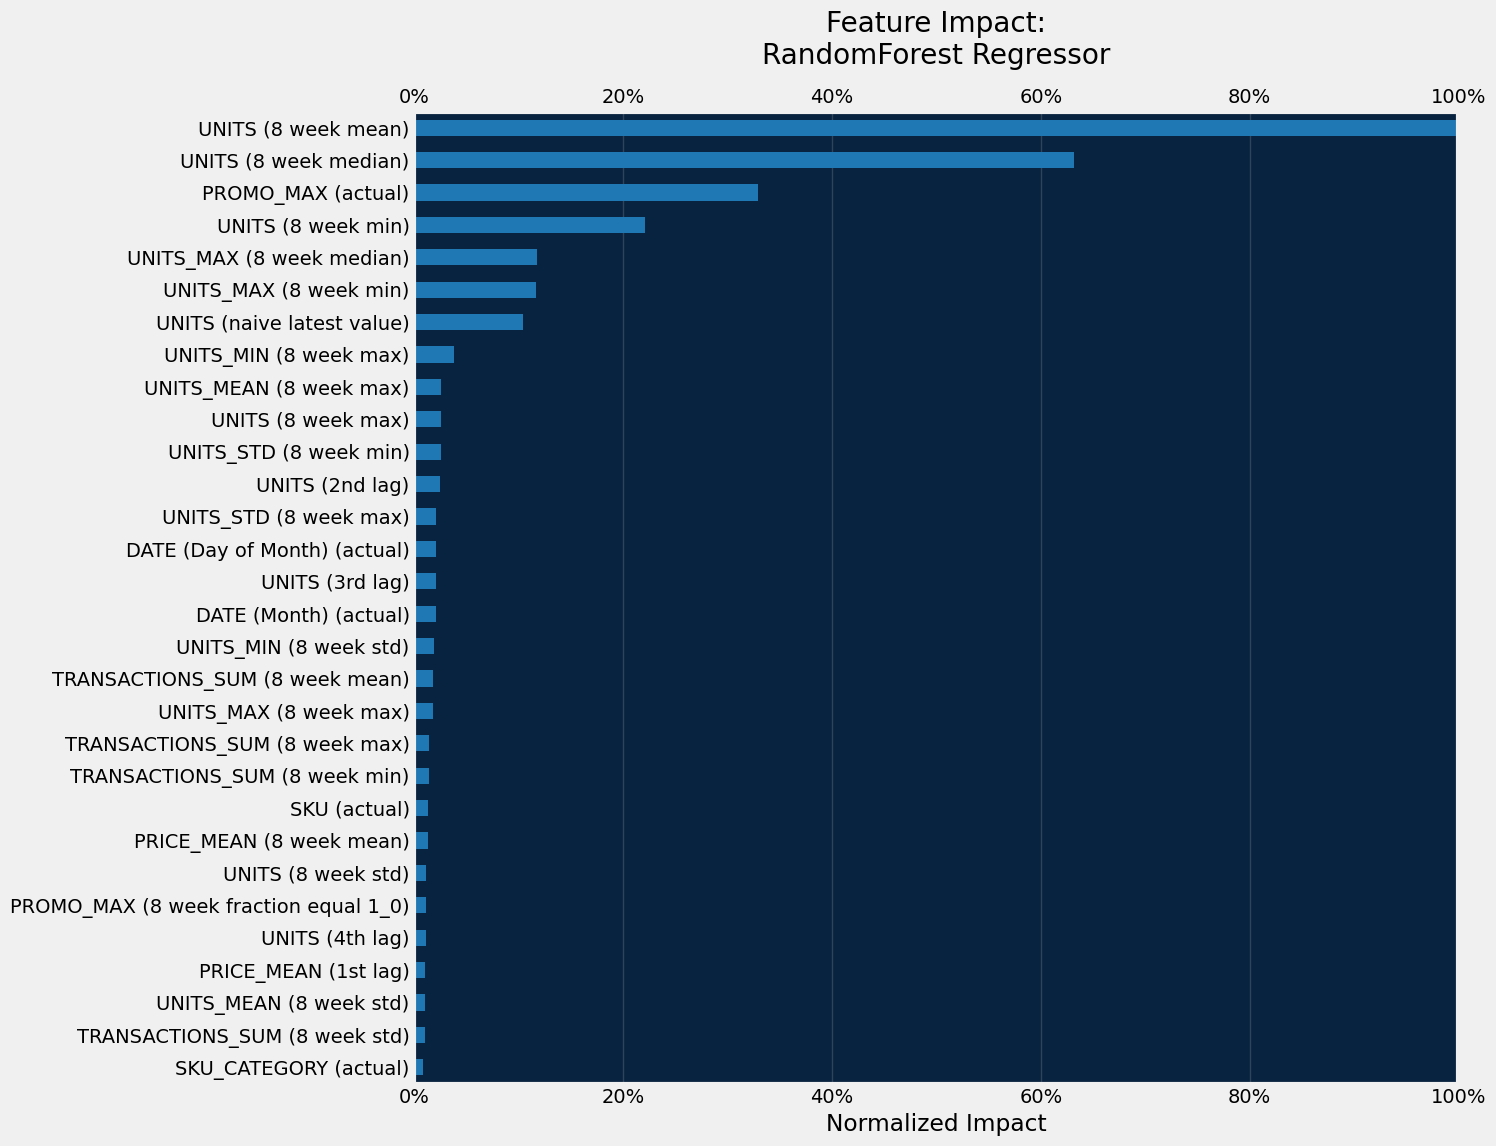

In [25]:
dru.plot_feature_impacts(model_ongoing, top_n=30)

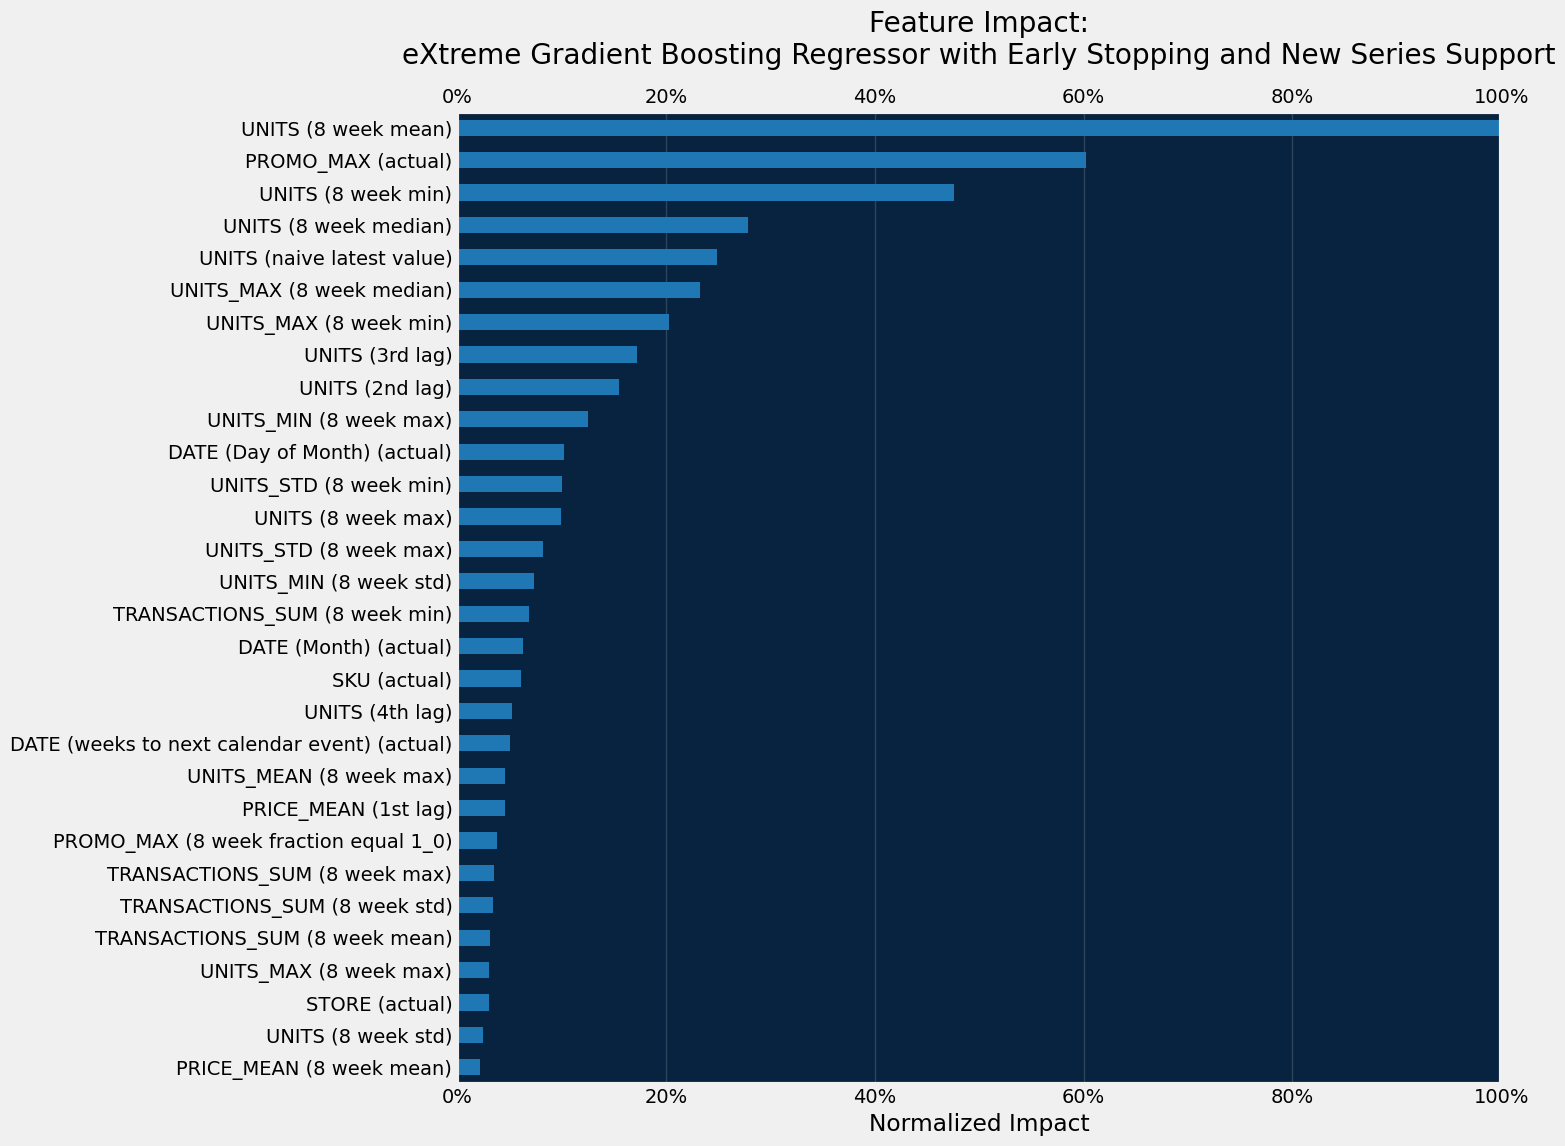

In [26]:
dru.plot_feature_impacts(model_warm_cold, top_n=30)

<a id='deployment'></a>
## Deployment

After you have selected your final model, you have multiple options for a production deployment in DataRobot MLOps. Creating a deployment will add your model package to the Model Registry and containerize all model artifacts, generate compliance documentation, expose a production quality REST API on a prediction server in your DataRobot cluster, and enable all lifecycle management functionality, like drift monitoring.

`dru.make_deployment` can be used to deploy a specific model by passing the `model.id`. If `model.id` is **None**, the DataRobot recommended model from the project will be deployed.

In this workflow you'll deploy two models in order to evaluate performance of the four solution methods mentioned earlier.

In [27]:
deployment_ongoing = dru.make_deployment(project_ongoing, target_drift_enabled=True, feature_drift_enabled=True)
deployment_warm_cold = dru.make_deployment(project_warm_cold, target_drift_enabled=True, feature_drift_enabled=True)

Deployment ID: 63f37dd112e78711a624490f; URL: https://app.datarobot.com/deployments/63f37dd112e78711a624490f/overview

Deployment ID: 63f37e06883317c56eb34329; URL: https://app.datarobot.com/deployments/63f37e06883317c56eb34329/overview



<a id='preds'></a>
## Make predictions

The scoring dataset should follow requirements to ensure the Batch Prediction API can make predictions: 
- Sort prediction rows by their series ID then timestamp, with the earliest row first.
- The dataset must contain rows without a target for the desired forecast window.

You can find more details on the scoring dataset structure [in the DataRobot documentation](https://app.datarobot.com/docs/api/reference/batch-prediction-api/batch-pred-ts.html#requirements-for-the-scoring-dataset).

### Batch predictions

Select the data from your data store, make predictions, and write them back to Snowflake once processed.

#### Ongoing series

In [28]:
intake_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "query": f"""select *, 'ongoing' PRED_TYPE from {db}.{schema}."ts_demand_forecasting_scoring" order by {series_id}, {date_col};"""
}

output_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "table": "ts_demand_forecasting_predictions",
    "schema": schema,
    "catalog": db,
    "create_table_if_not_exists": True,
    "statement_type": "insert"
}

pred_job = dru.make_predictions_from_deployment(deployment=deployment_ongoing, intake_settings=intake_settings, output_settings=output_settings,
                                 passthrough_columns_set='all'
                                )

#### Warm and cold series as-is

In [29]:
intake_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "query": f"""select *, 'warm_cold' PRED_TYPE from {db}.{schema}."ts_demand_forecasting_scoring_warm_cold" order by {series_id}, {date_col};"""
}

output_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "table": "ts_demand_forecasting_predictions",
    "schema": schema,
    "catalog": db,
    "create_table_if_not_exists": True,
    "statement_type": "insert"
}

pred_job = dru.make_predictions_from_deployment(deployment=deployment_warm_cold, intake_settings=intake_settings, output_settings=output_settings,
                                 passthrough_columns_set='all'
                                )

#### Warm and cold series after non-KA features were input with average values from ongoing series

In [30]:
intake_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "query": f"""select *, 'warm_cold_inp' PRED_TYPE from {db}.{schema}."ts_demand_forecasting_scoring_warm_cold_hist_inputted" order by {series_id}, {date_col};"""
}

output_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "table": "ts_demand_forecasting_predictions",
    "schema": schema,
    "catalog": db,
    "create_table_if_not_exists": True,
    "statement_type": "insert"
}

pred_job = dru.make_predictions_from_deployment(deployment=deployment_warm_cold, intake_settings=intake_settings, output_settings=output_settings,
                                 passthrough_columns_set='all'
                                )

## Get predictions

In the previous step, you ran prediction jobs from your registered data store (Snowflake) with your prediciton datasets:
- `ts_demand_forecasting_scoring` with ongoing series only was scored with `deployment_ongoing`
- `ts_demand_forecasting_scoring_warm_cold` with ongoing, warm and cold series was scored with `deployment_warm_cold`
- `ts_demand_forecasting_scoring_warm_cold_hist_inputted` with ongoing series and warm/cold series after non-KA features were input with average values from ongoing series was scored with `deployment_warm_cold`

The steps below will add the new prediction table, `ts_demand_forecasting_predictions_combined`, to the AI Catalog. This enables versioning of each prediction run, and completing the comparison between solutions. It contains the predictions for all solution methods mentioned earlier.

In [31]:
query = f"""
    select
        t.store_sku,
        t.store,
        t.sku_category,
        t.series_type,
        t.date,
        t.units,
        iff(t.series_type != 'ongoing' and po."UNITS (actual)_PREDICTION" is null,
            pm.prediction_ongoing_sku_cat_mean,
            po."UNITS (actual)_PREDICTION") prediction_ongoing,
        pc."UNITS (actual)_PREDICTION" prediction_warm_cold,
        pci."UNITS (actual)_PREDICTION" prediction_warm_cold_inp,
        iff(t.series_type = 'ongoing', po."UNITS (actual)_PREDICTION", pc."UNITS (actual)_PREDICTION") prediction_ongoing_warm_cold
    from {db}.{schema}."ts_demand_forecasting_test_warm_cold" t
    join {db}.{schema}."ts_demand_forecasting_predictions" pc 
        on t.store_sku = pc.store_sku 
        and t.date = pc.date 
        and pc.pred_type = 'warm_cold'
    join {db}.{schema}."ts_demand_forecasting_predictions" pci 
        on t.store_sku = pci.store_sku 
        and t.date = pci.date 
        and pci.pred_type = 'warm_cold_inp'
    left join {db}.{schema}."ts_demand_forecasting_predictions" po 
        on t.store_sku = po.store_sku 
        and t.date = po.date 
        and po.pred_type = 'ongoing'
    left join (
        select
            p.date,
            p.sku_category,
            avg(p."UNITS (actual)_PREDICTION") prediction_ongoing_sku_cat_mean
        from {db}.{schema}."ts_demand_forecasting_predictions" p
        where p.pred_type = 'ongoing'
        group by
            p.date,
            p.sku_category) pm 
            on t.sku_category = pm.sku_category 
            and t.date = pm.date
"""

In [32]:
# Create or get an existing data connection based on a query and upload a training dataset into AI Catalog

data_source_preds, dataset_preds = dru.create_dataset_from_data_source(
    data_source_name='ts_demand_forecasting_predictions_combined', query=query,
    data_store_id=data_store_id, credential_id=credential_id)

new data source: DataSource('ts_demand_forecasting_predictions_combined')


In [33]:
# Get predictions as a dataframe

df_preds = dataset_preds.get_as_dataframe()
df_preds[date_col] = pd.to_datetime(df_preds[date_col], format='%Y-%m-%d')
df_preds.sort_values([series_id, date_col], inplace=True)
print('the original data shape   :', df_preds.shape)
print('the total number of series:', df_preds[series_id].nunique())
print('the min date:', df_preds[date_col].min())
print('the max date:', df_preds[date_col].max())
df_preds.head()

the original data shape   : (280, 10)
the total number of series: 70
the min date: 2022-10-31 00:00:00
the max date: 2022-11-21 00:00:00


,STORE_SKU,STORE,SKU_CATEGORY,SERIES_TYPE,DATE,UNITS,PREDICTION_ONGOING,PREDICTION_WARM_COLD,PREDICTION_WARM_COLD_INP,PREDICTION_ONGOING_WARM_COLD
0,store_130_SKU_120931082,store_130,cat_1160,ongoing,2022-10-31,78.0,78.825333,77.779026,77.779026,78.825333
1,store_130_SKU_120931082,store_130,cat_1160,ongoing,2022-11-07,62.0,80.575847,78.455166,78.455166,80.575847
2,store_130_SKU_120931082,store_130,cat_1160,ongoing,2022-11-14,78.0,80.076640,80.292369,80.292369,80.076640
3,store_130_SKU_120931082,store_130,cat_1160,ongoing,2022-11-21,67.0,93.343021,89.633220,89.633220,93.343021
4,store_130_SKU_120969795,store_130,cat_1122,ongoing,2022-10-31,60.0,64.324464,66.912723,66.912723,64.324464


## Metrics and results

The table below shows `RMSE` for three different prediction methods per series type and in general:
- `PREDICTION_ONGOING`: warm and cold series predictions were computed as average prediction per SKU category from ongoing series predictions
- `PREDICTION_WARM_COLD`, `PREDICTION_WARM_COLD_INP` are predictions from `deployment_warm_cold`
- `PREDICTION_ONGOING_WARM_COLD` is a combination of predictions for ongoing series from `deployment_ongoing` and for warm and cold series from `deployment_warm_cold`

Results per series type:
- Ongoing series: the model without warm and cold support has slightly better results.
- Warm series: the predictions based on the data after imputation of non-KA features is better. The caveat is that it requires additional data prep.
- Cold: the model with warm and cold support shows the best results.

In general, the model with warm and cold series support provides decent results for all series types without additional pre- and post-processing steps which are required for the other three methods.

In [34]:
df_res = pd.concat([df_preds.groupby(['SERIES_TYPE']).apply(dru.rmse, target, 'PREDICTION_ONGOING'),
                    df_preds.groupby(['SERIES_TYPE']).apply(dru.rmse, target, 'PREDICTION_WARM_COLD'),
                    df_preds.groupby(['SERIES_TYPE']).apply(dru.rmse, target, 'PREDICTION_WARM_COLD_INP'),
                    df_preds.groupby(['SERIES_TYPE']).apply(dru.rmse, target, 'PREDICTION_ONGOING_WARM_COLD'),
                    ], axis=1)
df_res = pd.concat([df_res, 
                    pd.DataFrame([[dru.rmse(df_preds, target, 'PREDICTION_ONGOING'),
                                   dru.rmse(df_preds, target, 'PREDICTION_WARM_COLD'),
                                   dru.rmse(df_preds, target, 'PREDICTION_WARM_COLD_INP'),
                                   dru.rmse(df_preds, target, 'PREDICTION_ONGOING_WARM_COLD'),
                                   ]], index=['total'])]).round(1)
df_res.columns = ['RMSE_ONGOING', 'RMSE_WARM_COLD', 'RMSE_WARM_COLD_HIST_INP', 'RMSE_ONGOING_WARM_COLD']
df_res.style.format("{:.1f}").highlight_min(color='green', axis=1)

,RMSE_ONGOING,RMSE_WARM_COLD,RMSE_WARM_COLD_HIST_INP,RMSE_ONGOING_WARM_COLD
cold,106.9,42.6,95.9,42.6
ongoing,52.7,53.5,53.5,52.7
warm,74.0,39.5,36.9,39.5
total,66.3,50.2,59.6,49.6


## Data drift

To trust a model to power mission-critical operations, you need to have confidence in all aspects of model deployment. Model monitoring is the close tracking of the performance of models in production used to identify potential issues before they impact the business. Monitoring ranges from whether the service is reliably providing predictions in a timely manner and without errors to ensuring the predictions themselves are reliable.

The predictive performance of a model typically starts to diminish as soon as it’s deployed. For example, someone might be making live predictions on a dataset with sales data, but the customer’s behavioral patterns might have changed due to an economic crisis, market volatility, natural disaster, or even the weather. Models trained on older data that no longer represents the current reality might not just be inaccurate, but irrelevant, leaving the prediction results meaningless or even harmful. Without dedicated production model monitoring, the user or business owner cannot know or be able to detect when this happens. If model accuracy starts to decline without detection, the results can impact a business, expose it to risk, and destroy user trust.

DataRobot automatically monitors model deployments and offers a central hub for detecting errors and model accuracy decay as soon as possible. For each deployment, DataRobot provides a status banner—model-specific information is also available on the Deployments [inventory](https://docs.datarobot.com/en/docs/mlops/manage-mlops/deploy-inventory.html) page.

The example below shows how [the data drift](https://docs.datarobot.com/en/docs/mlops/monitor/data-drift.html) can be retrieved for the selected deployment.

In [35]:
df_drifts_ongoing = dru.get_target_and_feature_drift(deployment_ongoing)
print(df_drifts_ongoing.shape)
df_drifts_ongoing.head()

(26, 7)


,feature,feature_impact,drift_score,metric,start,end,is_target
0,UNITS (actual),1.000000,0.083913,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,1
1,UNITS (8 week mean),1.000000,0.087867,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
2,UNITS (8 week median),0.521989,0.050813,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
3,PROMO_MAX (actual),0.304943,0.006202,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
4,UNITS (8 week min),0.164225,0.095454,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0


The plot below shows the feature drift for `deployment_ongoing`. As it sometimes happens, several low importance features has drifted above the threshold 0.2 (the metric is PSI)

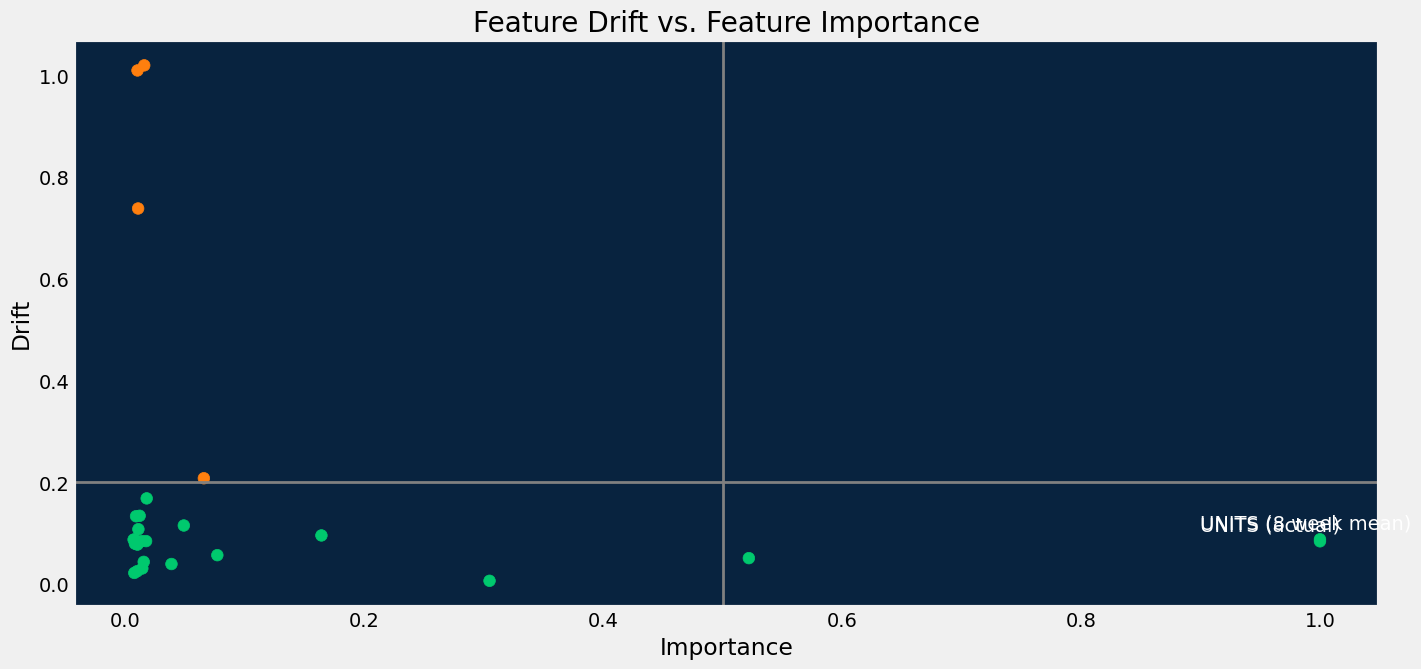

In [36]:
dru.plot_drift_data(df_drifts_ongoing)

In [37]:
df_drifts_warm_cold = dru.get_target_and_feature_drift(deployment_warm_cold)
print(df_drifts_warm_cold.shape)
df_drifts_warm_cold.head()

(26, 7)


,feature,feature_impact,drift_score,metric,start,end,is_target
0,UNITS (actual),1.000000,0.117193,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,1
1,UNITS (8 week median),1.000000,0.292019,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
2,UNITS (8 week mean),0.968483,0.340999,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
3,PROMO_MAX (actual),0.768503,0.009155,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0
4,UNITS (8 week min),0.574672,0.330424,psi,2023-02-13 15:00:00+00:00,2023-02-20 15:00:00+00:00,0


The plot below shows the feature drift for `deployment_warm_cold`. Since you've made predictions with new series data and with additional imputation, several high importance features (the  importance is above 0.5, the drift is above 0.2) have drifted significantly.

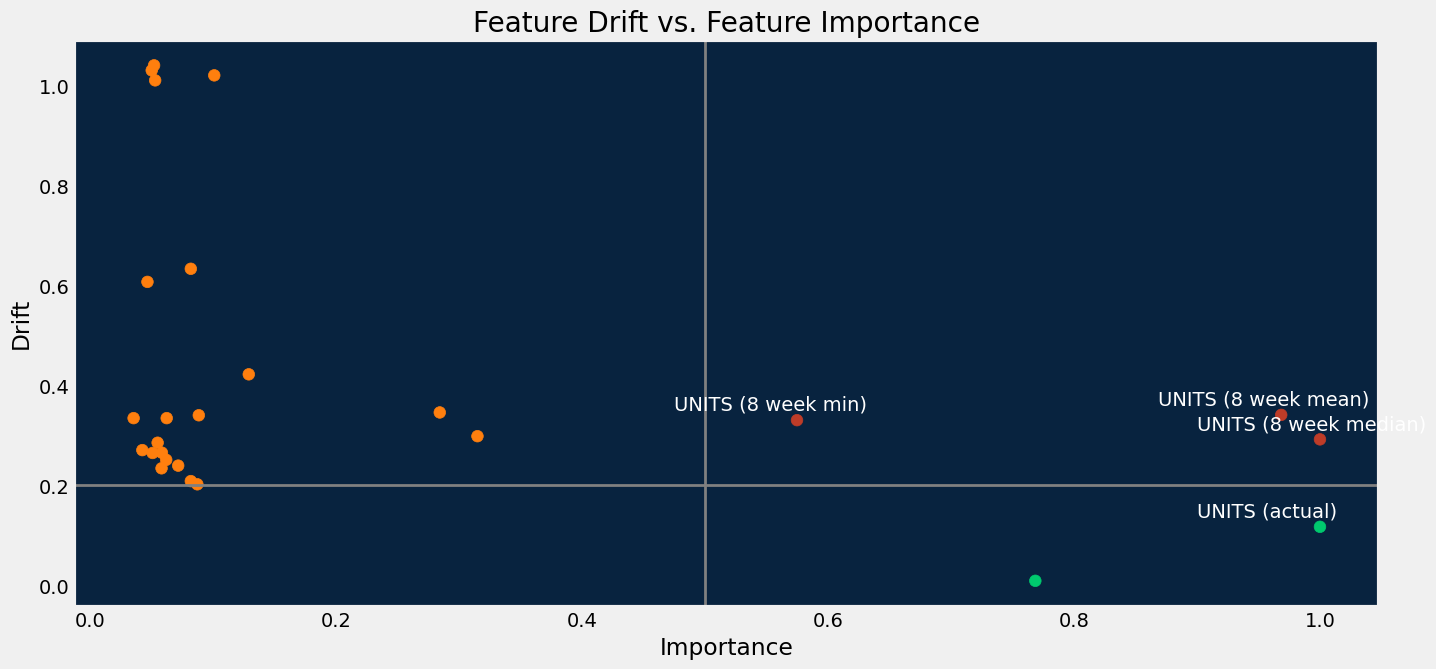

In [38]:
dru.plot_drift_data(df_drifts_warm_cold)

## Conclusion

This notebook's workflow provides a repeatable framework from project setup to model deployment for times series data with multiple series (SKUs) with full, partial, and no history. This notebook presented frameworks for aggregation at the SKU and store-SKU level, and provided functions to streamline building and deploying multiple models from time series projects with and without segmented modeling enabled. It also provided helpers to extract series and model insights for common challenges seen in real-world data, and multiple methods for prediction and production deployment with full MLOps capabilities. The steps above provide many of the building blocks necessary for evaluating and experimenting on complex, real-world multi-series data.

An extremely common practice in the field is running experiments with various feature derivation windows and forecast distances. For example, if a business desires predictions 6 months out, and you have a few years of history, the best model to predict 3-6 months out may not be the same model that best predicts 1-3 months out. Conceptually, recall that DataRobot generates a wide range of lagged features based on the Feature Derivation Window. The features that best capture short-term predictions (with customer data, this can be lags of a few days or weeks and product interactions), can quite reasonably not be the same set of features that capture mid to long-term predictions. This can be compounded when you have a large number of series/SKUs; many blueprints are designed to learn interactions and trends across series, which again can have different interaction effects and periodicities. This is usually a good indicator to use Segmented Modeling. At the same time, one model could work quite well depending on the dynamics of your target. There is no silver bullet, hence the benefit of learning how to apply automation to rapidly experiment and improve your models.

In all cases, ensuring your validation period captures the behavior you want to predict, and that your backtests do as well, is vitally important. 

Try experimenting with different Forecast Distances and compare the important features across projects. Enable the various project settings in the `params` dictionary in the **Modeling** section, and enable Segmented Modeling. Identify and evaluate the performance of some of the partial history series. Getting comfortable with these common workflows will accelerate your time to value in future projects. 

## Delete project artifacts 

Optional.

In [39]:
# # Uncomment and run this cell to remove everything you added in DataRobot during this session

# dr.Dataset.delete(dataset_train.id)
# dr.Dataset.delete(dataset_scoring.id)
# dr.Dataset.delete(dataset_calendar.id)
# dr.Dataset.delete(dataset_preds.id)

# data_source_train.delete()
# data_source_scoring.delete()
# data_source_calendar.delete()
# data_source_preds.delete()

# deployment_ongoing.delete()
# deployment_warm_cold.delete()

# project_ongoing.delete()
# project_warm_cold.delete()

# dr.CalendarFile.delete(calendar_id)